# [without library] <font color="orange">Binary Classification using Logistic Regression
</font>

### Based on - [2010] Generative and Discriminative Classifiers : Naive Bayes and Logistic Regression - <font color=magenta>Tom Mitchell</font>

<img src="../assets/images/my-notes-logistic-regression-images/log_reg_display.png">

## Introduction

This notebook implements <font color=blue>Binomial Logistic Regression</font>. It performs <font color=blue>binary classification</font> on a generated dataset consisting of two gaussian distributed clusters of points in a 2-dimensional space. The prediction accuracy for a learning dataset of 100 points is <font color=blue>90+%</font> if the clusters overlap slightly and <font color=blue>98-100%</font> if the clusters do not overlap.

Resources:
- [Generative and Discriminative Classifiers : Naive Bayes and Logistic Regression](https://www.cs.cmu.edu/~tom/mlbook/NBayesLogReg.pdf)

Towards the end, I have included a <font color=blue>sidebar</font> on the <font color=magenta>Binomial Logistic Regression</font>. 

## Taxonomy and Notes

Logistic Regression is a <font color=blue>probabilistic</font> classifier. But, it does not model the complete distribution P(X, Y). It is only interested in discriminating among classes. It does that by __computing P(Y \| X) directly__ from the training data. Hence, it is a <font color=blue>probabilistic-discriminative</font> classifier. The classifier's <font color=magenta>sigmoid</font> function is <font color=blue>linear</font> in terms of weights and bias for the features. It is <font color=blue>parametric</font> (weights and bias are the parameters). Binomial Logistic Regression is <font color=blue>binary</font>. The model can be modified to use <font color=magenta>softmax</font> instead of sigmoid, and it becomes <font color=blue>Multiclass</font> Logistic Regression.

In summary, Logistic Regression is:
- Probabilistic
- Discriminative
- Binary and Multiclass
- Linear
- Parametric

The density estimation of P(Y\|X) is parametric, <font color=blue>point estimation</font>, using <font color=blue>Maximum Likelihood Estimation (MLE)</font>.

The computation of P(Y\|X) is <font color=red>not in closed-form</font>. So, a numerical method like <font color=blue>Gradient Descent</font> is used to optimize the model's cost function.

<img src="../assets/images/my-notes-logistic-regression-images/log_reg_mmap.png">

## Imports

In [1]:
from math import log # to calculate posterior probability
import numpy as np #arrays for data points
from numpy.random import rand, normal, randint #gaussian distributed data points
from numpy import dot #vector dot product for the linear kernel
from numpy import mean, std #mean and standard deviation for gaussian probabilities
from scipy.stats import norm #gaussian probabilities
import pandas as pd #input
import seaborn as sns #plotting
import matplotlib.pyplot as plt #plotting
%matplotlib inline

## X_m, Y

### Data Configuration

In [2]:
M = 100 #number of data points
cols = ['X0', 'X1', 'X2', 'Y'] #column names of the dataframe
n_features = len(cols)-1 #number of dimensions
K = 2 #number of classes
loc_scale = [(5, 1), (7, 1)] #mean and std of data points belonging to each class

### Generate Data
Gaussian clusters in 2D numpy arrays

In [3]:
def generate_X_m_and_Y(M, K, n_features, loc_scale):
    #X_m, Y
    # we use this extra count (+1) to accomodate for X0 = 1 (the attribute for bias)
    X_m = np.ones((K, (int)(M/2), n_features), dtype=float) #initialize data points
    Y = np.empty((K, (int)(M/2)), dtype=int) #initialize the class labels

    for k in range(K): #for each class, generate data points #create data points for each class
        #create data points for class k using gaussian (normal) distribution
        X_m[k][:, 1:] = normal(loc=loc_scale[k][0], scale=loc_scale[k][1], size=((int)(M/2), n_features-1))
        #append features/columns after the bias (first) column
        #X_m[:, 1:] = X
        #create labels (0, 1) for class k (0, 1).
        Y[k] = np.full(((int)(M/2)), k, dtype=int)
    X_m = X_m.reshape(M, n_features) #collapse the class axis
    Y = Y.reshape(M) #collapse the class axis
    X_m.shape, Y.shape #print shapes
    
    return X_m, Y

X_m, Y = generate_X_m_and_Y(M, K, n_features, loc_scale)
X_m.shape, Y.shape

((100, 3), (100,))

### X_m, Y in DataFrame

In [4]:
def create_df_from_array(X_m, Y, n_features, cols):
    #create series from each column of X_m, and a series from Y
    l_series = [] #list of series, one for each column
    for feat in range(n_features): #create series from each column of X_m
        l_series.append(pd.Series(X_m[:, feat])) #create series from a column of X_m
    l_series.append(pd.Series(Y[:])) #create series from Y

    frame = {col : series for col, series in zip(cols, l_series)} #map of column names to series
    df = pd.DataFrame(frame) #create dataframe from map

    return df

df = create_df_from_array(X_m, Y, n_features, cols)
df.sample(n = 10)

,X0,X1,X2,Y
89,1.0,5.582885,7.660471,1
43,1.0,4.320468,5.115238,0
5,1.0,5.034319,5.274385,0
91,1.0,5.784753,7.475163,1
26,1.0,6.418753,3.360426,0
44,1.0,5.006697,3.317916,0
93,1.0,6.344121,7.284477,1
15,1.0,5.568940,2.963496,0
85,1.0,6.859079,5.874983,1
19,1.0,5.417719,5.529503,0


<AxesSubplot:xlabel='X1', ylabel='X2'>

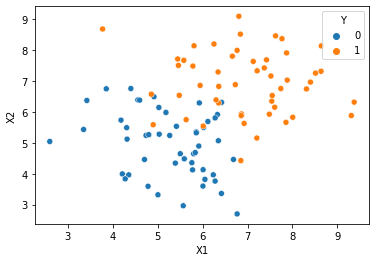

In [5]:
#scatter plot of data points
#class column Y is passed in as hue
sns.scatterplot(x=cols[1], y=cols[2], hue=cols[3], data=df)

## Model

### Model Configuration

In [6]:
learning_rate = 0.001
convergence_cost_diff = 0.0005

### Linear Combination of Weights / Coefficients and Features

<a href="https://www.codecogs.com/eqnedit.php?latex=w_{0}&plus;\sum_{i=1}^{n}w_{i}X_{i}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?w_{0}&plus;\sum_{i=1}^{n}w_{i}X_{i}" title="w_{0}+\sum_{i=1}^{n}w_{i}X_{i}" /></a>

In [7]:
def lin_com(W, X):
    return np.dot(W, X)

### Probability of -ve class

<a href="https://www.codecogs.com/eqnedit.php?latex=P\left&space;(&space;Y=0|X&space;\right&space;)=\frac{1}{1&plus;e^{\left&space;(w_{0}&plus;\sum_{i=1}^{n}w_{i}X_{i}&space;\right&space;)}}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?P\left&space;(&space;Y=0|X&space;\right&space;)=\frac{1}{1&plus;e^{\left&space;(w_{0}&plus;\sum_{i=1}^{n}w_{i}X_{i}&space;\right&space;)}}" title="P\left ( Y=0|X \right )=\frac{1}{1+e^{\left (w_{0}+\sum_{i=1}^{n}w_{i}X_{i} \right )}}" /></a>

In [8]:
def prob_y0_x(w, x):
    lc = lin_com(w, x)
    return 1/(1 + np.exp(lc))

### Probability of +ve class

<a href="https://www.codecogs.com/eqnedit.php?latex=P\left&space;(&space;Y=1|X&space;\right&space;)=\frac{e^{\left&space;(&space;w_{0}&plus;\sum_{i=1}^{n}w_{i}X_{i}&space;\right&space;)}}{1&plus;e^{\left&space;(w_{0}&plus;\sum_{i=1}^{n}w_{i}X_{i}&space;\right&space;)}}" target="_blank"><img src="https://latex.codecogs.com/gif.latex?P\left&space;(&space;Y=1|X&space;\right&space;)=\frac{e^{\left&space;(&space;w_{0}&plus;\sum_{i=1}^{n}w_{i}X_{i}&space;\right&space;)}}{1&plus;e^{\left&space;(w_{0}&plus;\sum_{i=1}^{n}w_{i}X_{i}&space;\right&space;)}}" title="P\left ( Y=1|X \right )=\frac{e^{\left ( w_{0}+\sum_{i=1}^{n}w_{i}X_{i} \right )}}{1+e^{\left (w_{0}+\sum_{i=1}^{n}w_{i}X_{i} \right )}}" /></a>

In [9]:
def prob_y1_x(w, x):
    lc = lin_com(w, x)
    return np.exp(lc)/(1 + np.exp(lc))

### <font color='magenta'>Conditional Data Log-Likelihood</font>

<img src="../assets/images/cross-entropy.png">

If we look at the equation below, the term 'Y ln P(Y)' is the <font color=blue>cross entropy between the true probability Y (=1) and the predicted probability</font>. Since when Y=1, we have (1-Y) = 0, and when Y=0, we have (1-Y) = 1, only one term per data point is non-zero. So, conditional data log-likelihood is basically a <font color=magenta>sum of cross entropies</font>. The lower the cross entropy, the better the prediction. Hence, this function is a cost (loss) function.

<a href="https://www.codecogs.com/eqnedit.php?latex=l(W)=\sum_{l}^{}Y^{l}ln\;&space;P\left&space;(Y^{l}=1|X^{l},W&space;\right&space;)&plus;\left&space;(1-Y^{l}&space;\right&space;)ln\;&space;P\left&space;(Y^{l}=0|X^{l},W&space;\right&space;)" target="_blank"><img src="https://latex.codecogs.com/gif.latex?l(W)=\sum_{l}^{}Y^{l}ln\;&space;P\left&space;(Y^{l}=1|X^{l},W&space;\right&space;)&plus;\left&space;(1-Y^{l}&space;\right&space;)ln\;&space;P\left&space;(Y^{l}=0|X^{l},W&space;\right&space;)" title="l(W)=\sum_{l}^{}Y^{l}ln\; P\left (Y^{l}=1|X^{l},W \right )+\left (1-Y^{l} \right )ln\; P\left (Y^{l}=0|X^{l},W \right )" /></a>

In [10]:
#conditional data log-likelihood ln(P(Y|X,W))
def cond_data_log_likelihood(X_m, Y, w):
    likelihood = 0.0
    for i in range(len(X_m)):
        likelihood += (Y[i]*log(prob_y1_x(w, X_m[i])) + (1 - Y[i])*log(prob_y0_x(w, X_m[i])) )
    return (likelihood)

### <font color='magenta'>Gradient along attribute 'i'</font>

<a href="https://www.codecogs.com/eqnedit.php?latex=\frac{\partial&space;l\left&space;(&space;W&space;\right&space;)}{\partial&space;w_{i}}=\sum_{l}^{}X_{i}^{l}\left&space;(&space;Y^{l}-\hat{P}\left&space;(Y^{l}=1|X^{l},W&space;\right&space;)&space;\right&space;)" target="_blank"><img src="https://latex.codecogs.com/gif.latex?\frac{\partial&space;l\left&space;(&space;W&space;\right&space;)}{\partial&space;w_{i}}=\sum_{l}^{}X_{i}^{l}\left&space;(&space;Y^{l}-\hat{P}\left&space;(Y^{l}=1|X^{l},W&space;\right&space;)&space;\right&space;)" title="\frac{\partial l\left ( W \right )}{\partial w_{i}}=\sum_{l}^{}X_{i}^{l}\left ( Y^{l}-\hat{P}\left (Y^{l}=1|X^{l},W \right ) \right )" /></a>

In [11]:
#gradient along the attribute 'j'
def gradient(X_m, Y, W, j):
    grad = 0.0
    #iterate over all data-points
    for i in range(len(X_m)):
        grad += X_m[i][j]*(Y[i] - prob_y1_x(W, X_m[i]))
    return grad

### <font color='magenta'>Gradients along attributes</font>

In [12]:
#gradient along each attribute
def gradients(X_m, Y, W):
    #gradient along each attribute
    grads = np.zeros(len(W), dtype=float)
    for j in range(len(W)):
        grads[j] = gradient(X_m, Y, W, j)
        
    return grads

### Apply gradients on coefficients

<a href="https://www.codecogs.com/eqnedit.php?latex=w_{i}\leftarrow&space;w_{i}&plus;\eta&space;\sum_{l}^{}X_{i}^{l}\left&space;(&space;Y^{l}-\hat{P}\left&space;(Y^{l}=1|X^{l},W&space;\right&space;)&space;\right&space;)" target="_blank"><img src="https://latex.codecogs.com/gif.latex?w_{i}\leftarrow&space;w_{i}&plus;\eta&space;\sum_{l}^{}X_{i}^{l}\left&space;(&space;Y^{l}-\hat{P}\left&space;(Y^{l}=1|X^{l},W&space;\right&space;)&space;\right&space;)" title="w_{i}\leftarrow w_{i}+\eta \sum_{l}^{}X_{i}^{l}\left ( Y^{l}-\hat{P}\left (Y^{l}=1|X^{l},W \right ) \right )" /></a>

In [13]:
def apply_gradient(W, grads, learning_rate):
    return (W + (learning_rate * grads))

### Training Algorithm

<img src="../assets/images/grad_descent.png">

In [14]:
def train(X_m, Y, W, learning_rate):
    #learn
    prev_max = cond_data_log_likelihood(X_m, Y, W)
    grads = gradients(X_m, Y, W)
    W = apply_gradient(W, grads, learning_rate)
    new_max = cond_data_log_likelihood(X_m, Y, W)
    #summary print
    i_print = 0
    while(abs(prev_max - new_max) > convergence_cost_diff):
        if(i_print % 500) == 0:
            print('Cost:', prev_max)
        prev_max = new_max
        grads = gradients(X_m, Y, W)
        W = apply_gradient(W, grads, learning_rate)
        new_max = cond_data_log_likelihood(X_m, Y, W)
        i_print += 1

    return W

### Learn

In [15]:
#weights
W = np.zeros((n_features), dtype=float)
W = train(X_m, Y, W, learning_rate)

Cost: -69.31471805599459
Cost: -49.707947324850565
Cost: -40.87854558929088
Cost: -35.85466773616585
Cost: -32.65388264792396
Cost: -30.444903169173813
Cost: -28.830852125987995
Cost: -27.600808997259257
Cost: -26.63289105803656
Cost: -25.8518897927959
Cost: -25.20890607913062
Cost: -24.670769018536692
Cost: -24.21417569334356
Cost: -23.822268801602643
Cost: -23.482546876964133
Cost: -23.18553887871831


#### <font color=magenta>weights (coefficients)</font>

In [16]:
print('The learnt weights (coefficients) are:', W)

The learnt weights (coefficients) are: [-14.97508012   1.16796148   1.35110071]


## Prediction

### Generate Data
Gaussian clusters in 2D numpy arrays

In [17]:
X_m, Y = generate_X_m_and_Y(M, K, n_features, loc_scale) #generate test data points

### Predict

In [18]:
Y_pred = [prob_y1_x(W, X) for X in X_m]
Y_pred_class = [0 if y < 0.5 else 1 for y in Y_pred] #decision based on predicted margin

### Predicted X_m, Y in DataFrame

In [19]:
df = create_df_from_array(X_m, Y, n_features, cols) #create test dataframe
df['Y_pred_margin'] = Y_pred #append the prediction margin column
df['Y_pred_class'] = Y_pred_class #append the class
df.sample(n = 10)

,X0,X1,X2,Y,Y_pred_margin,Y_pred_class
37,1.0,5.234051,5.226969,0,0.141882,0
47,1.0,4.146087,6.144546,0,0.138154,0
22,1.0,6.182099,3.720378,0,0.061340,0
27,1.0,5.694109,5.687429,0,0.345181,0
43,1.0,5.386995,2.323051,0,0.003893,0
38,1.0,5.202220,5.670654,0,0.224878,0
99,1.0,7.099939,7.113818,1,0.949255,1
79,1.0,7.165353,6.450322,1,0.891757,1
29,1.0,4.034987,5.389770,0,0.048326,0
66,1.0,6.995258,6.390637,1,0.861703,1


<AxesSubplot:xlabel='X1', ylabel='X2'>

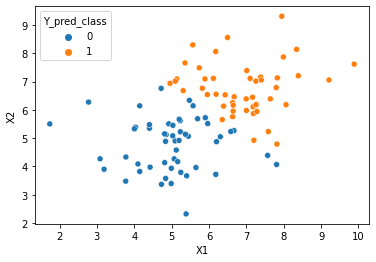

In [20]:
#scatter plot of data points
#class column Y is passed in as hue
sns.scatterplot(x=cols[1], y=cols[2], hue='Y_pred_class', data=df)

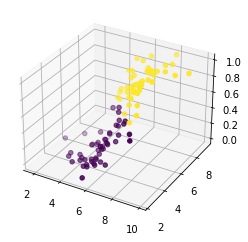

In [21]:
Y_pred_np = np.array(Y_pred)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_m[:, 1], X_m[:, 2], Y_pred, c = (Y_pred_np>0.5))
plt.show()

### <font color=magenta>Prediction Accuracy</font>

In [22]:
Y_pred_corr = (Y==Y_pred_class)
num_corr = len(Y_pred_corr[Y_pred_corr == True])
print('Accuracy:', (num_corr/M)*100, '%')

Accuracy: 88.0 %


## Sidebar - <font color=blue>Binomial Logistic Regression</font>

### P(Y\|X) <font color=magenta>directly</font>?

Actually, the term likelihood can be used for P(X\|Y) as well as P(Y\|X). It can be used for <font color=blue>any distribution</font>. In Naive Bayes, we estimate params (mu/sigma, or frequencies) for distribution P(X\|Y). But, in Logistic Regression, we estimate W (the weight vector W in W.X) to maximize likelihood of the distribution P(Y\|X) -  <font color=blue>this is what we call as estimating P(Y\|X) directly</font>.


<img src="../assets/images/my-notes-logistic-regression-images/log_reg_mmap_note_likelihood.png">

### <font color=magenta>Linear</font> Boundary

<img src="../assets/images/my-notes-logistic-regression-images/log_reg_mmap_note_linear.png">

### Why Logistic Regression?

<img src="../assets/images/my-notes-logistic-regression-images/log_reg_why.png">

### Model and Cost Function

<img src="../assets/images/my-notes-logistic-regression-images/0001.jpg">

### Derivatives for Gradient Descent

<img src="../assets/images/my-notes-logistic-regression-images/0002.jpg">

### Regularized Logistic Regression

<img src="../assets/images/my-notes-logistic-regression-images/0003.jpg">